Welcome to my first Machine learning Computer Vision project. In this project I'd like to practice a problem of object detection. I will train a Neural Network of an architecture called Faster R-CNN. Plan is to be able to detect and draw bounding boxes around tomatoes in images. Here we go.

In [0]:
#!pip install tensorflow==2.0


In [0]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage import io
from shutil import copyfile
import sys
import time

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
tf.__version__

'2.2.0-rc4'

In [4]:
!wget https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
!wget https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv
!wget https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv


--2020-05-08 18:04:15--  https://storage.googleapis.com/openimages/2018_04/train/train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194033454 (1.1G) [text/csv]
Saving to: ‘train-annotations-bbox.csv’

train-annotations-b 100%[===================>]   1.11G  79.3MB/s    in 18s     

2020-05-08 18:04:33 (62.0 MB/s) - ‘train-annotations-bbox.csv’ saved [1194033454/1194033454]

--2020-05-08 18:04:35--  https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.187.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.187.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638407721 (609M) [text/cs

In [0]:
images_boxable_fname = 'train-images-boxable-with-rotation.csv'
annotations_bbox_fname = 'train-annotations-bbox.csv'
class_descriptions_fname = 'class-descriptions-boxable.csv'

In [6]:
images_boxable = pd.read_csv(images_boxable_fname)
images_boxable.head()

,ImageID,Subset,OriginalURL,OriginalLandingURL,License,AuthorProfileURL,Author,Title,OriginalSize,OriginalMD5,Thumbnail300KURL,Rotation
0,4fa8054781a4c382,train,https://farm3.staticflickr.com/5310/5898076654...,https://www.flickr.com/photos/michael-beat/589...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/michael-beat/,Michael Beat,...die FNF-Kerze,4405052,KFukvivpCM5QXl5SqKe41g==,https://c1.staticflickr.com/6/5310/5898076654_...,0.0
1,b37f763ae67d0888,train,https://c1.staticflickr.com/1/67/197493648_628...,https://www.flickr.com/photos/drstarbuck/19749...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/drstarbuck/,Karen,Three boys on a hill,494555,9IzEn38GRNsVpATuv7gzEA==,https://c3.staticflickr.com/1/67/197493648_628...,0.0
2,7e8584b0f487cb9e,train,https://c7.staticflickr.com/8/7056/7143870979_...,https://www.flickr.com/photos/circasassy/71438...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/circasassy/,CircaSassy,A Christmas carol and The cricket on the heart...,2371584,3hQwu0iSzY1VIoXiwp0/Mg==,https://c7.staticflickr.com/8/7056/7143870979_...,0.0
3,86638230febe21c4,train,https://farm5.staticflickr.com/5128/5301868579...,https://www.flickr.com/photos/ajcreencia/53018...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/ajcreencia/,Alex,Abbey and Kenny,949267,onB+rCZnGQg5PRX7xOs18Q==,https://c4.staticflickr.com/6/5128/5301868579_...,NaN
4,249086e72671397d,train,https://c6.staticflickr.com/4/3930/15342460029...,https://www.flickr.com/photos/codnewsroom/1534...,https://creativecommons.org/licenses/by/2.0/,https://www.flickr.com/people/codnewsroom/,COD Newsroom,Suburban Law Enforcement Academy 20th Annivers...,6541758,MjpaAVbMAWbCusSaxI1D7w==,https://c1.staticflickr.com/4/3930/15342460029...,0.0


In [7]:
annotations_bbox = pd.read_csv(annotations_bbox_fname)
annotations_bbox.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,0,0,0
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,0,0,0
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,0,0,0
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,0,0,0
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,0,0,0


In [8]:
#number of tomatoes in dataset:
annotations_bbox.LabelName.value_counts()['/m/07j87']

6254

In [9]:
class_descriptions = pd.read_csv(class_descriptions_fname, header=None)
class_descriptions.head()

,0,1
0,/m/011k07,Tortoise
1,/m/011q46kg,Container
2,/m/012074,Magpie
3,/m/0120dh,Sea turtle
4,/m/01226z,Football


In [0]:
def plot_bbox(img_id):
  img_url = images_boxable.loc[images_boxable["ImageID"]==img_id]['OriginalURL'].values[0]
  img = io.imread(img_url)
  height, width, channel = img.shape
  print(f"Image: {img.shape}")
  bboxs = annotations_bbox[annotations_bbox['ImageID']==img_id]
  for index, row in bboxs.iterrows():
      xmin = row['XMin']
      xmax = row['XMax']
      ymin = row['YMin']
      ymax = row['YMax']
      xmin = int(xmin*width)
      xmax = int(xmax*width)
      ymin = int(ymin*height)
      ymax = int(ymax*height)
      label_name = row['LabelName']
      class_series = class_descriptions[class_descriptions[0]==label_name]
      class_name = class_series[1].values[0]
      print(f"Coordinates: {xmin,ymin}, {xmax,ymax}")
      cv2.rectangle(img, (xmin,ymin), (xmax,ymax), (255,0,0), 5)
      font = cv2.FONT_HERSHEY_SIMPLEX
      cv2.putText(img, class_name, (xmin,ymin-10), font, 3, (0,255,0), 5)
  plt.figure(figsize=(15,10))
  plt.title('Image with Bounding Box')
  plt.imshow(img)
  plt.axis("off")
  plt.show()

In [11]:
least_objects_img_ids = annotations_bbox["ImageID"].value_counts().tail(50).index.values
for img_id in random.sample(list(least_objects_img_ids), 5):
  plot_bbox(img_id)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
class_descriptions.loc[class_descriptions[1].isin(['Tomato', 'Tortoise', 'Flower'])]


,0,1
0,/m/011k07,Tortoise
391,/m/07j87,Tomato
455,/m/0c9ph5,Flower


In [13]:
# Find the label_name for 'tomato', 'tortoise' and 'flower' classes
tomato_pd = class_descriptions[class_descriptions[1]=='Tomato']
tortoise_pd = class_descriptions[class_descriptions[1]=='Tortoise']
flower_pd = class_descriptions[class_descriptions[1]=='Flower']

label_name_tomato = tomato_pd[0].values[0]
label_name_tortoise = tortoise_pd[0].values[0]
label_name_flower = flower_pd[0].values[0]

tomato_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_tomato]
tortoise_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_tortoise]
flower_bbox = annotations_bbox[annotations_bbox['LabelName']==label_name_flower]

print('There are %d tomatoes in the dataset' %(len(tomato_bbox)))
print('There are %d tortoise in the dataset' %(len(tortoise_bbox)))
print('There are %d flowers in the dataset' %(len(flower_bbox)))
tomato_img_id = tomato_bbox['ImageID']
tortoise_img_id = tortoise_bbox['ImageID']
flower_img_id = flower_bbox['ImageID']

tomato_img_id = np.unique(tomato_img_id)
tortoise_img_id = np.unique(tortoise_img_id)
flower_img_id = np.unique(flower_img_id)
print('There are %d images which contain tomatoes' % (len(tomato_img_id)))
print('There are %d images which contain tortoise' % (len(tortoise_img_id)))
print('There are %d images which contain flowers' % (len(flower_img_id)))

There are 6254 tomatoes in the dataset
There are 1998 tortoise in the dataset
There are 345296 flowers in the dataset
There are 1283 images which contain tomatoes
There are 1324 images which contain tortoise
There are 62716 images which contain flowers


In [0]:
# here I've chosen only 10 images for speed, change it to your liking
n = 10
subtomato_img_id = random.sample(list(tomato_img_id), n)
subtortoise_img_id = random.sample(list(tortoise_img_id), n)
subflower_img_id = random.sample(list(flower_img_id), n)

subtomato_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtomato_img_id)]
subtortoise_pd = images_boxable.loc[images_boxable['ImageID'].isin(subtortoise_img_id)]
subflower_pd = images_boxable.loc[images_boxable['ImageID'].isin(subflower_img_id)]

subtomato_dict = subtomato_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subtortoise_dict = subtortoise_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()
subflower_dict = subflower_pd[["ImageID", "OriginalURL"]].set_index('ImageID')["OriginalURL"].to_dict()

In [15]:
classes = ['Tomato', 'Tortoise', 'Flower']
mappings = [subtomato_dict, subtortoise_dict, subflower_dict]


# download images
for idx, obj_type in enumerate(classes):
  n_issues = 0
  # create the directory
  if not os.path.exists(obj_type):
    os.mkdir(obj_type)
  for img_id, url in mappings[idx].items():
    try:
      img = io.imread(url)
      saved_path = os.path.join(obj_type, img_id+".jpg")
      io.imsave(saved_path, img)
    except Exception as e:
      n_issues += 1
  print(f"Images Issues: {n_issues}")

Images Issues: 1
Images Issues: 0
Images Issues: 0


In [0]:
train_path = 'train'
test_path = 'test'


In [0]:
!mkdir train test
#!ls Tomato | wc -l
#os.listdir('Tomato')

Creating a 80% train data set with 20% test 

In [0]:

random.seed(1)
for i in range(len(classes)):
    all_imgs = os.listdir(classes[i])
    all_imgs = [f for f in all_imgs if not f.startswith('.')]
    random.shuffle(all_imgs)
    
    limit = int(n*0.8)

    train_imgs = all_imgs[:limit]
    test_imgs = all_imgs[limit:]
    
    # copy each classes' images to train directory
    for j in range(len(train_imgs)):
        original_path = os.path.join(classes[i], train_imgs[j])
        new_path = os.path.join(train_path, train_imgs[j])
        copyfile(original_path, new_path)
    
    # copy each classes' images to test directory
    for j in range(len(test_imgs)):
        original_path = os.path.join(classes[i], test_imgs[j])
        new_path = os.path.join(test_path, test_imgs[j])
        copyfile(original_path, new_path)

In [19]:
label_names = [label_name_tomato, label_name_tortoise, label_name_flower]

train_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# Find boxes in each image and put them in a dataframe
train_imgs = os.listdir(train_path)
train_imgs = [name for name in train_imgs if not name.startswith('.')]

for i in range(len(train_imgs)):
    sys.stdout.write('Parse train_imgs ' + str(i) + '; Number of boxes: ' + str(len(train_df)) + '\r')
    sys.stdout.flush()
    img_name = train_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                train_df = train_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [20]:
train_df.head()
train_df.shape


(117, 6)

Image: (2736, 3648, 3)
Coordinates: (3162, 627), (3547, 994)
Coordinates: (0, 898), (535, 1548)
Coordinates: (2510, 1026), (3178, 1634)
Coordinates: (161, 0), (3645, 2382)
Coordinates: (0, 914), (513, 1201)
Coordinates: (0, 1965), (3645, 2726)
Coordinates: (734, 111), (1440, 809)
Coordinates: (1568, 437), (1869, 772)
Coordinates: (2859, 0), (3588, 481)
Coordinates: (3438, 446), (3645, 734)
Coordinates: (0, 2398), (307, 2701)
Coordinates: (0, 1263), (430, 1541)
Coordinates: (2710, 1329), (3023, 1575)


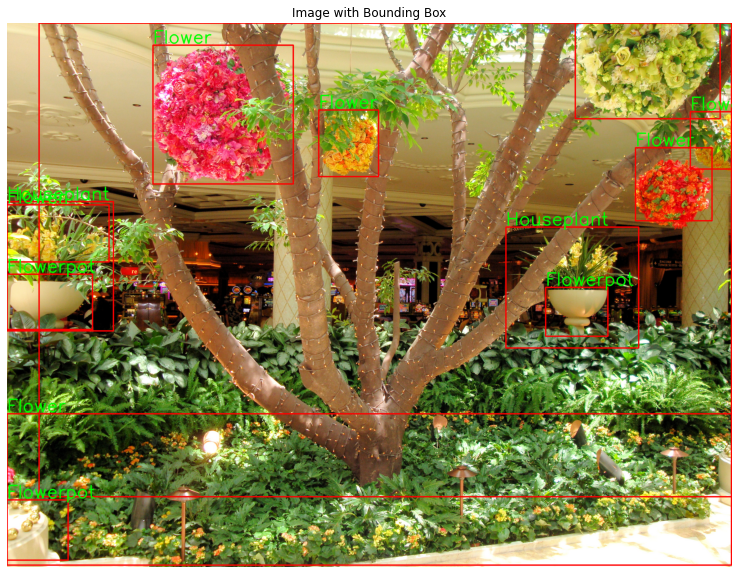

In [21]:
train_img_ids = train_df["FileName"].head().str.split(".").str[0].unique()
for img_id in train_img_ids:
  plot_bbox(img_id)

In [22]:
test_df = pd.DataFrame(columns=['FileName', 'XMin', 'XMax', 'YMin', 'YMax', 'ClassName'])

# find boxes in each image and put them in a dataframe
test_imgs = os.listdir(test_path)
test_imgs = [name for name in test_imgs if not name.startswith('.')]

for i in range(len(test_imgs)):
    sys.stdout.write('Parse test_imgs ' + str(i) + '; Number of boxes: ' + str(len(test_df)) + '\r')
    sys.stdout.flush()
    img_name = test_imgs[i]
    img_id = img_name[0:16]
    tmp_df = annotations_bbox[annotations_bbox['ImageID']==img_id]
    for index, row in tmp_df.iterrows():
        labelName = row['LabelName']
        for i in range(len(label_names)):
            if labelName == label_names[i]:
                test_df = test_df.append({'FileName': img_name, 
                                            'XMin': row['XMin'], 
                                            'XMax': row['XMax'], 
                                            'YMin': row['YMin'], 
                                            'YMax': row['YMax'], 
                                            'ClassName': classes[i]}, 
                                           ignore_index=True)

In [23]:
test_df.shape

(8, 6)

In [0]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [0]:
train_df = pd.read_csv('train.csv')

# for training
with open("annotation.txt", "w+") as f:
  for idx, row in train_df.iterrows():
      img = cv2.imread('train/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)

      google_colab_file_path = 'drive/My Drive/Include/Studies/Self studies/Colab Notebooks/Open Images Dataset v4 (Bounding Boxes)/train'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')

In [26]:
test_df = pd.read_csv('test.csv')

# for test
with open("test_annotation.txt", "w+") as f:
  for idx, row in test_df.iterrows():
      sys.stdout.write(str(idx) + '\r')
      sys.stdout.flush()
      img = cv2.imread('test/' + row['FileName'])
      height, width = img.shape[:2]
      x1 = int(row['XMin'] * width)
      x2 = int(row['XMax'] * width)
      y1 = int(row['YMin'] * height)
      y2 = int(row['YMax'] * height)
      
      google_colab_file_path = 'drive/My Drive/Include/Studies/Self studies/Colab Notebooks/Open Images Dataset v4 (Bounding Boxes)/test'
      fileName = os.path.join(google_colab_file_path, row['FileName'])
      className = row['ClassName']
      f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + className + '\n')